Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2023/2024  
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Četvrta laboratorijska vježba: Procjena parametara, probabilistički grafički modeli, grupiranje

*Verzija: 1.0
Zadnji put ažurirano: 1. listopada 2021.*

(c) 2015-2023 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **21. siječnja 2024. u 23:59h**

------------------------------

### Pravila predaje
Predajom vježbe potvrđujete sljedeće točke:
1. Niste od drugoga primili pomoć pri rješavanju vježbe;
2. Atribuirali ste dijelove koda koji su preuzeti s interneta referencirajući ih u komentarima;
3. Niste koristili dijelove koda s interneta koji su specifični za laboratorijsku vježbu;
4. Niste koristili UI-asistente za kodiranje kao npr. GitHub Copilot (uključivo alate generativne UI, kao što je ChatGPT).

**Povreda bilo kojeg od gornjih pravila smatra se prekršajem te povlači akademske sankcije.**

### Upute

Četvrta laboratorijska vježba sastoji se od osam zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import pgmpy as pgm
%pylab inline

def plot_silhouette(n_clusters, X):
    # Kôd preuzet s http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = plt.cm.get_cmap("Dark2")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("Vrijednosti koeficijenta siluete")
    ax1.set_ylabel("Oznaka grupe")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = plt.cm.get_cmap("Dark2")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='o', s=30, lw=0, alpha=1,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers # changed to black
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="black", alpha=1, s=100, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=80, edgecolor='k')

    ax2.set_xlabel(r"$x_1$")
    ax2.set_ylabel(r"$x_2$")

    plt.show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 1. Procjena maksimalne izglednosti

#### (a)

Definirajte funkciju izglednosti $\mathcal{L}(\mu|\mathcal{D})$ za skup $\mathcal{D}=\{x^{(i)}\}_{i=1}^N$ Bernoullijevih varijabli. Neka od $N$ varijabli njih $m$ ima vrijednost 1 (npr. od $N$ bacanja novčića, $m$ puta smo dobili glavu). Definirajte funkciju izglednosti tako da je parametrizirana s $N$ i $m$, dakle definirajte funkciju $\mathcal{L}(\mu|N,m)$. 

In [2]:
def L(mu, N, m):
    return mu**m * (1 - mu)**(N - m)

#### (b)

Prikažite funkciju $\mathcal{L}(\mu|N,m)$ za (1) $N=10$ i $m=1,2,5,9$ te za (2) $N=100$ i $m=1,10,50,90$ (dva zasebna grafikona).

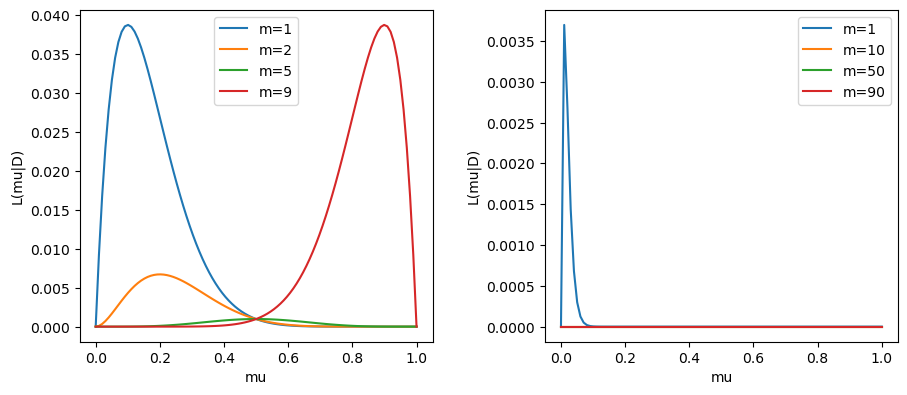

In [3]:
m_values1 = [1, 2, 5, 9]
m_values2 = [1, 10, 50, 90]

fig, axis = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5) # https://www.geeksforgeeks.org/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python/
mu_i = np.linspace(0, 1, num=100)
N=10

for m in m_values1:
    axis[0].plot(mu_i, L(mu=mu_i, N=N, m=m), label='m='+str(m))

axis[0].set_xlabel('mu')
axis[0].set_ylabel('L(mu|D)')
axis[0].legend()

N=100
for m in m_values2:
    axis[1].plot(mu_i, L(mu=mu_i, N=N, m=m), label='m='+str(m))

axis[1].set_xlabel('mu')
axis[1].set_ylabel('L(mu|D)')
axis[1].legend()

**Q:** Koja vrijednost odgovara ML-procjenama i zašto?

**A:** Odgovara vrijednost m/N zato što je ML (Maximum Likelihood) procjena zapravo jednaka relativnoj frekvenciji događaja u uzorku.

#### (c)

Prikažite funkciju $\mathcal{L}(\mu|N,m)$ za $N=10$ i $m=\{0,9\}$.

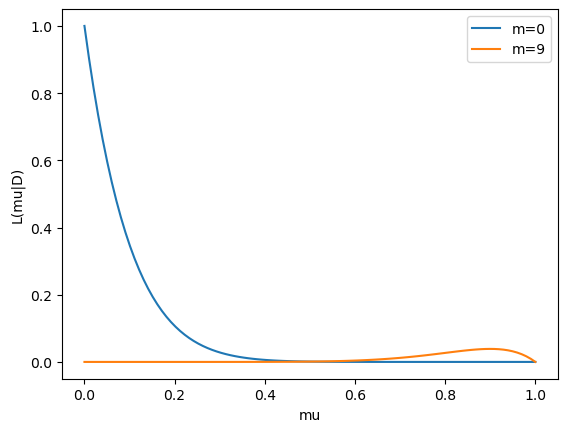

In [4]:
plt.xlabel('mu')
plt.ylabel('L(mu|D)')
ms = [0, 9]
for m in ms:
    plt.plot(mu_i, L(mu=mu_i, N=10, m=m), label='m='+str(m))
    
plt.legend()

**Q:** Koja je ML-procjena za $\mu$ i što je problem s takvom procjenom u ovome slučaju?

**A:** ML procjena u ovakvom slučaju je 0. Problem je što se ML procjena bazira isključivo na podatcima te može lako dovesti do prenaučenosti modela.

### 2. Procjena maksimalne aposteriorne vjerojatnosti

#### (a)

Prikažite beta-distribuciju $B(\mu|\alpha,\beta)$ za različite kombinacije parametara $\alpha$ i $\beta$, uključivo $\alpha=\beta=1$ te $\alpha=\beta=2$.

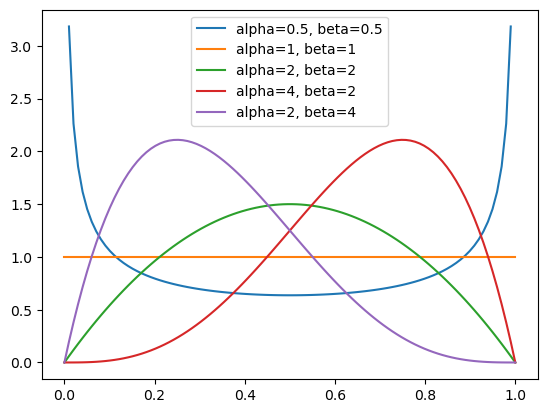

In [5]:
from scipy.stats import beta

alphas = [0.5, 1, 2, 4, 2]
betas = [0.5, 1, 2, 2, 4]

for i in range(len(alphas)):
    pdf = beta.pdf(x=mu_i, a=alphas[i], b=betas[i])
    plt.plot(mu_i, pdf, label='alpha='+str(alphas[i])+", beta="+str(betas[i]))
    
plt.legend()

**Q:** Koje parametere biste odabrali za modeliranje apriornog znanja o parametru $\mu$ za novčić za koji mislite da je "donekle pravedan, ali malo češće pada na glavu"? Koje biste parametre odabrali za novčić za koji držite da je posve pravedan? Zašto uopće koristimo beta-distribuciju, a ne neku drugu?

**A:** Neka je m broj slučajeva kada novčić pada na glavu, odnosno mu = m/N. Ukoliko je novčić "donekle pravedan, ali malo češće pada na glavu", to znači da će mu > 0.5. Možemo vidjeti iz grafa da je to slučaj kada je alpha=4, beta=2. Kada želimo modelirati slučaj kada je novčić pravedan onda koristimo beta-distribuciju gdje alpha=beta=2. Beta-distribuciju koristimo zato što je ona konjugatna apriorna distribucija za izglednost parametara (tj. konjugatna je s Bernoulli distribucijom) te njihovim umnoškom ćemo dobiti aposteriornu distribuciju koja je konjugatna s apriornom.

#### (b)

Definirajte funkciju za izračun zajedničke vjerojatnosti $P(\mu,\mathcal{D}) = P(\mathcal{D}|\mu) \cdot P(\mu|\alpha,\beta)$ te prikažite tu funkciju za $N=10$ i $m=9$ i nekolicinu kombinacija parametara $\alpha$ i $\beta$. 

In [6]:
def aposteriori_beta(likelihood, apriori_beta):
    return likelihood * apriori_beta

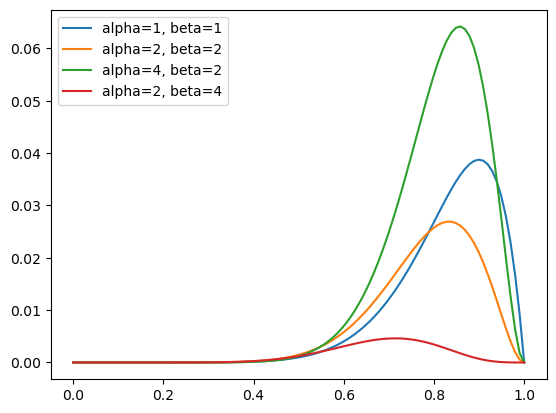

In [7]:
alphas = [1, 2, 4, 2] # za beta=alpha=0.5 apriori beta pdf je +beskonacno
betas = [1, 2, 2, 4]
N, m = 10, 9

for i in range(len(alphas)):
    apriori_pdf = beta.pdf(x=mu_i, a=alphas[i], b=betas[i])
    likelihood = L(mu=mu_i, N=N, m=m)
    aposteriori_pdf = aposteriori_beta(likelihood=likelihood, apriori_beta=apriori_pdf)
    plt.plot(mu_i, aposteriori_pdf, label='alpha='+str(alphas[i])+", beta="+str(betas[i]))
    
plt.legend()

**Q**: Koje vrijednosti odgovaraju MAP-procjeni za $\mu$? Usporedite ih sa ML-procjenama.

**A**: MAP procjena kombinira MLE procjenu zajedno s pretpostavkom o apriori distribuciji (odnosno funkciji gustoće). Možemo primjetiti da je MAP procjena odmaknuta od MLE procjene i da se nalazi između MLE procjene i apriori distribucije.

#### (c)

Za $N=10$ i $m=1$, na jednome grafikonu prikažite sve tri distribucije: $P(\mu,\mathcal{D})$, $P(\mu|\alpha,\beta)$ i $\mathcal{L}(\mu|\mathcal{D})$.

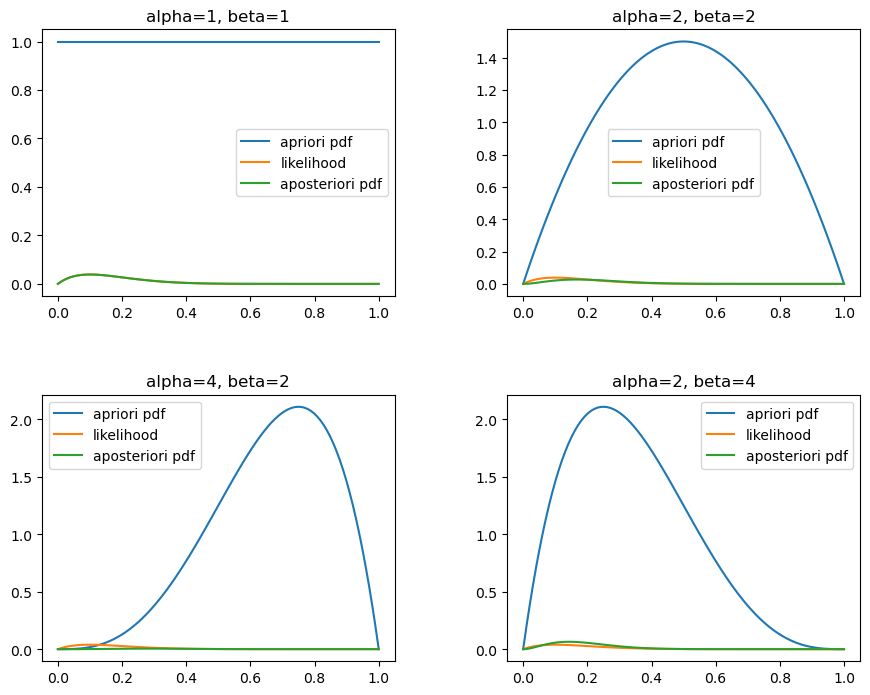

In [8]:
N, m = 10, 1
fig, axis = plt.subplots(2, 2, figsize=(10, 8))
fig.tight_layout(pad=5)
row, col = 0, 0

for i in range(len(alphas)):
    apriori_pdf = beta.pdf(x=mu_i, a=alphas[i], b=betas[i])
    likelihood = L(mu=mu_i, N=N, m=m)
    aposteriori_pdf = aposteriori_beta(likelihood=likelihood, apriori_beta=apriori_pdf)
    axis[row, col].set_title('alpha='+str(alphas[i])+", beta="+str(betas[i]))
    axis[row, col].plot(mu_i, apriori_pdf, label='apriori pdf')
    axis[row, col].plot(mu_i, likelihood, label='likelihood')
    axis[row, col].plot(mu_i, aposteriori_pdf, label='aposteriori pdf')
    axis[row, col].legend()
    col += 1
    if col % 2 == 0 and col != 0:
        row += 1
        col = 0
    

### 3. Analiza skupa podataka *Iris*

#### (a)

Učitajte skup podataka *Iris* korištenjem funkcije [`load_iris`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html). Taj skup sadrži $n=4$ značajke i $K=3$ klase. Odaberite jednu klasu i odaberite sve primjere iz te klase, dok ostale primjere zanemarite (**u nastavku radite isključivo s primjerima iz te jedne klase**). Vizualizirajte podatke tako da načinite 2D-prikaze za svaki par značajki (šest grafikona; za prikaz je najjednostavnije koristiti funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter)).

**NB:** Mogla bi Vam dobro dući funkcija [`itertools.combinations`](https://docs.python.org/2/library/itertools.html#itertools.combinations).

In [9]:
from sklearn.datasets import load_iris
import itertools as it

data = load_iris()
# versicolor
X_versicolor = data.data[data.target == 1]
y_versicolor = data.target[data.target == 1]
#print(len(X_versicolor), len(y_versicolor))

0 1 sepal length (cm),sepal width (cm)
0 2 sepal length (cm),petal length (cm)
0 3 sepal length (cm),petal width (cm)
1 2 sepal width (cm),petal length (cm)
1 3 sepal width (cm),petal width (cm)
2 3 petal length (cm),petal width (cm)


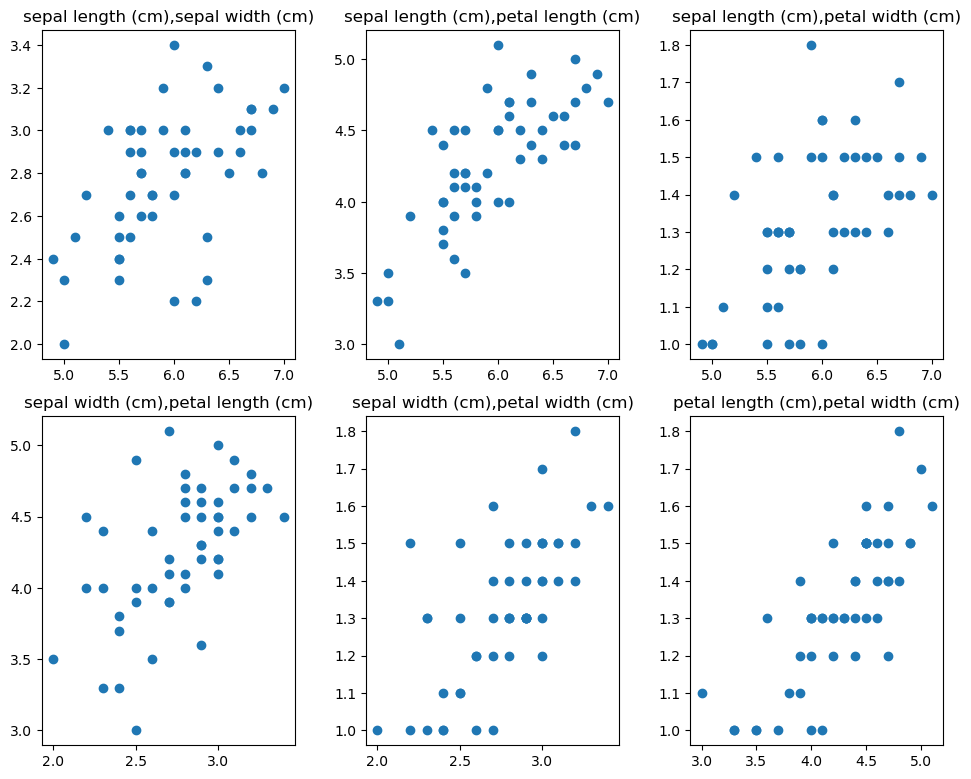

In [10]:
fig, axis = plt.subplots(2, 3, figsize=(10, 8))
fig.tight_layout(pad=2)
row, col = 0, 0

for i in range(X_versicolor.shape[1]):
    for j in range(i + 1, X_versicolor.shape[1]):
        print(i, j, data.feature_names[i]+","+data.feature_names[j])
        axis[row, col].set_title(data.feature_names[i]+","+data.feature_names[j])
        axis[row, col].scatter(X_versicolor[:, i], X_versicolor[:, j])
        col += 1
        if col % 3 == 0:
            row += 1
            col = 0

#### (b)

Pogledajte opis modula [`stats`](http://docs.scipy.org/doc/scipy-0.14.0/reference/stats.html) te proučite funkciju [`norm`](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.norm.html#scipy.stats.norm). Implementirajte funkciju log-izglednosti za parametre $\mu$ i $\sigma^2$ normalne distribucije.

In [11]:
from scipy.stats import norm

def L_gauss(x, mi, sigma):
    #N = x.shape[0]
    #first_part = -(N / 2) * np.log(2 * np.pi)
    #second_part = - N * np.log(sigma)
    #third_part = - np.sum((x - mi)**2) / (2 * sigma**2)
    #return first_part + second_part + third_part
    return np.sum(norm.logpdf(x, loc=mi, scale=sigma))

#### (c)
Izračunajte ML-procjene za $(\mu, \sigma^2)$ za svaku od $n=4$ značajki iz skupa *Iris*. Ispišite log-izglednosti tih ML-procjena. 

In [12]:
for i in range(X_versicolor.shape[1]):
    mu, sigma = np.mean(X_versicolor[:, i]), np.var(X_versicolor[:, i])
    print(str(i) + ". " + data.feature_names[i])
    print("\tmu:", mu)
    print("\tsigma:", sigma)
    print("\tLog-likelihood:", str(L_gauss(x=X_versicolor[:, i], mi=mu, sigma=np.sqrt(sigma))))

0. sepal length (cm)
	mu: 5.936
	sigma: 0.261104
	Log-likelihood: -37.37601457039468
1. sepal width (cm)
	mu: 2.7700000000000005
	sigma: 0.09650000000000002
	Log-likelihood: -12.491619894303717
2. petal length (cm)
	mu: 4.26
	sigma: 0.21640000000000004
	Log-likelihood: -32.68125835998836
3. petal width (cm)
	mu: 1.3259999999999998
	sigma: 0.038324
	Log-likelihood: 10.595047019604118


**Q**: Možete li, na temelju dobivenih log-izglednosti, zaključiti koja se značajka najbolje pokorava normalnoj distribuciji?

**A**: Značajka s najvećom log izglednosti. 

#### (d)

Proučite funkciju [`pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) za izračun Pearsonovog koeficijenta korelacije. Izračunajte koeficijente korelacije između svih četiri značajki u skupu *Iris*. 

In [13]:
from scipy.stats import pearsonr
for i in range(X_versicolor.shape[1]):
    for j in range(i + 1, X_versicolor.shape[1]):
        print("Pearson correleation coefficient between feature ("+str(i)+") and feature ("+str(j)+"):",
              "\t"+str(pearsonr(X_versicolor[:, i], X_versicolor[:, j])), sep='\n')
        
        

Pearson correleation coefficient between feature (0) and feature (1):
	PearsonRResult(statistic=0.5259107172828247, pvalue=8.771860011973769e-05)
Pearson correleation coefficient between feature (0) and feature (2):
	PearsonRResult(statistic=0.7540489585920163, pvalue=2.586189505280909e-10)
Pearson correleation coefficient between feature (0) and feature (3):
	PearsonRResult(statistic=0.5464610715986298, pvalue=4.035421526067971e-05)
Pearson correleation coefficient between feature (1) and feature (2):
	PearsonRResult(statistic=0.5605220916929818, pvalue=2.3021679804283912e-05)
Pearson correleation coefficient between feature (1) and feature (3):
	PearsonRResult(statistic=0.6639987200241114, pvalue=1.4666608142179647e-07)
Pearson correleation coefficient between feature (2) and feature (3):
	PearsonRResult(statistic=0.7866680885228169, pvalue=1.2719157063236564e-11)


#### (e)

Proučite funkciju [`cov`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html) te izračunajte ML-procjenu za kovarijacijsku matricu za skup *Iris*. Usporedite pristranu i nepristranu procjenu. Pokažite da se razlika (srednja apsolutna i kvadratna) smanjuje s brojem primjera (npr. isprobajte za $N/4$ i $N/2$ i $N$ primjera).

In [14]:
N = X_versicolor.shape[0]
Ns = [round(N/4), round(N/2), round(N)]

for n in Ns:
    biased_cov = np.cov(X_versicolor[:n, :], rowvar=False, bias=True)
    unbiased_cov = np.cov(X_versicolor[:n, :], rowvar=False, bias=False)
    print("N=", n)
    print("Biased ML estimate for covariance matrix:", biased_cov, sep='\n')
    print("Unbiased ML estimate for covariance matrix:", unbiased_cov, sep='\n')
    print("Mean absolute error:", np.mean(np.abs(biased_cov - unbiased_cov)))
    print("MSE:", np.mean((biased_cov - unbiased_cov)**2))

N= 12
Biased ML estimate for covariance matrix:
[[0.48909722 0.21590278 0.31569444 0.09048611]
 [0.21590278 0.14743056 0.15513889 0.05951389]
 [0.31569444 0.15513889 0.23638889 0.07263889]
 [0.09048611 0.05951389 0.07263889 0.03409722]]
Unbiased ML estimate for covariance matrix:
[[0.53356061 0.2355303  0.34439394 0.09871212]
 [0.2355303  0.16083333 0.16924242 0.06492424]
 [0.34439394 0.16924242 0.25787879 0.07924242]
 [0.09871212 0.06492424 0.07924242 0.03719697]]
Mean absolute error: 0.015487294823232339
MSE: 0.0003577977359811825
N= 25
Biased ML estimate for covariance matrix:
[[0.288256 0.105088 0.179056 0.049872]
 [0.105088 0.119424 0.085088 0.044656]
 [0.179056 0.085088 0.189056 0.061472]
 [0.049872 0.044656 0.061472 0.040864]]
Unbiased ML estimate for covariance matrix:
[[0.30026667 0.10946667 0.18651667 0.05195   ]
 [0.10946667 0.1244     0.08863333 0.04651667]
 [0.18651667 0.08863333 0.19693333 0.06403333]
 [0.05195    0.04651667 0.06403333 0.04256667]]
Mean absolute error: 0.

### 4. Probabilistički grafički modeli -- Bayesove mreže

Ovaj zadatak bavit će se Bayesovim mrežama, jednim od poznatijih probabilističkih grafičkih modela (*probabilistic graphical models*; PGM). Za lakše eksperimentiranje koristit ćemo programski paket [`pgmpy`](https://github.com/pgmpy/pgmpy). Molimo Vas da provjerite imate li ovaj paket te da ga instalirate ako ga nemate. Upute se nalaze na gornjoj poveznici. Za korisnike Anaconde, najlakše je upisati `conda install -c ankurankan pgmpy` (ili `pip install pgmpy` ako ne prolazi) unutar Anaconda Prompta (i ponovno pokrenuti Jupyter).

Prvo ćemo pogledati udžbenički primjer s prskalicom. U ovom primjeru razmatramo Bayesovu mrežu koja modelira zavisnosti između oblačnosti (slučajna varijabla $C$), kiše ($R$), prskalice ($S$) i mokre trave ($W$). U ovom primjeru također pretpostavljamo da već imamo parametre vjerojatnosnih distribucija svih čvorova. Ova mreža prikazana je na sljedećoj slici:

![This](http://www.fer.unizg.hr/_download/repository/bayes-net-sprinkler.jpg)

Koristeći paket `pgmpy`, konstruirajte Bayesovu mrežu iz gornjeg primjera. Zatim, koristeći **egzaktno** zaključivanje, postavite sljedeće posteriorne upite: $P(w=1)$, $P(s=1|w=1)$, $P(r=1|w=1)$, $P(c=1|s=1, r=1)$ i $P(c=1)$. Provedite zaključivanje na papiru i uvjerite se da ste ispravno konstruirali mrežu. Pomoći će vam službena dokumentacija te primjeri korištenja (npr. [ovaj](https://github.com/pgmpy/pgmpy/blob/dev/examples/Monty%20Hall%20Problem.ipynb)).

In [15]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [16]:
# Defining the network structure
model = BayesianModel([("C", "S"), ("C", "R"), ("S", "W"), ("R", "W")]) # lista cvorova

cpd_c = TabularCPD("C", 2, [[0.5], [0.5]])
cpd_s = TabularCPD("S", 2, [[0.5, 0.9], [0.5, 0.1]], evidence=["C"], evidence_card=[2])
cpd_r = TabularCPD("R", 2, [[0.8, 0.2], [0.2, 0.8]], evidence=["C"], evidence_card=[2])
cpd_w = TabularCPD("W", 2, [
    [1.0, 0.1, 0.1, 0.01], [0.0, 0.9, 0.9, 0.99]
], evidence=["S", "R"], evidence_card=[2, 2])

model.add_cpds(cpd_c, cpd_s, cpd_r, cpd_w)

In [17]:
model.check_model()

True

In [18]:
infer = VariableElimination(model)
P_w = infer.query(["W"])
print(P_w) # P(W=1) = 0.

+------+----------+
| W    |   phi(W) |
+======+==========+
| W(0) |   0.3529 |
+------+----------+
| W(1) |   0.6471 |
+------+----------+


In [19]:
P_s_w = infer.query(["S"], evidence={"W": 1})
print(P_s_w)

+------+----------+
| S    |   phi(S) |
+======+==========+
| S(0) |   0.5702 |
+------+----------+
| S(1) |   0.4298 |
+------+----------+


In [20]:
P_r_w = infer.query(["R"], evidence={"W": 1})
print(P_r_w)

+------+----------+
| R    |   phi(R) |
+======+==========+
| R(0) |   0.2921 |
+------+----------+
| R(1) |   0.7079 |
+------+----------+


In [21]:
P_c_s_r = infer.query(["C"], evidence={"S": 1, "R": 1})
print(P_c_s_r)

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.5556 |
+------+----------+
| C(1) |   0.4444 |
+------+----------+


In [22]:
P_c = infer.query(["C"])
print(P_c)

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.5000 |
+------+----------+
| C(1) |   0.5000 |
+------+----------+


**Q:** Koju zajedničku vjerojatnosnu razdiobu ova mreža modelira? Kako tu informaciju očitati iz mreže?

**A:** Modelira zajedničku vjerojatnost P(C,S,R,W) = P(C)P(S|C)P(R|C)P(W|S,R). Možemo očitati tako jer imamo potpuni (linearni) uređaj među čvorovima, tj. roditelji dolaze prije djece, pa onda samo očitavamo iz mreže, ukoliko strelice ulaze u neki čvor, on je uvjetno zavisan o tim čvorovima, odnosno svojim (direktnim) roditeljima. 

**Q:** U zadatku koristimo egzaktno zaključivanje. Kako ono radi?  

**A:** Egzaktno zaključivanje radi tako da mi zapravo dinamičkim programiranjem vjerojatnosti 

**Q:** Koja je razlika između posteriornog upita i MAP-upita?  

**A:** Posteriorni upit vraća vjerojatnosnu distribuciju dok MAP upit vraća najvjerojatniju vrijednost parametara za tu aposteriornu distribuciju.

**Q:** Zašto je vjerojatnost $P(c=1)$ drugačija od $P(c=1|s=1,r=1)$ ako znamo da čvorovi $S$ i $R$ nisu roditelji čvora $C$?

**A:** Zato što poznavanje vrijednosti podređenih čvorova utječe na vjerojatnost roditelja. Npr. U=1 -> učio puno, O=5 ili O=2. Poznavanje ocjene utječe na vjerojatnost je li neka osoba učila puno ili ne, što je ocjena bolja to je veća vjerojatnost da je ta osoba učila puno, a što je ocjena manja, vjerojatnost da je učila puno je manja. 


### 5. Efekt objašnjavanja

 **Efekt objašnjavanja** (engl. *explaining away*) zanimljiv je fenomen u kojem se događa da se dvije varijable "natječu" za objašnjavanje treće. Ovaj fenomen može se primijetiti na gornjoj mreži. U tom se slučaju varijable prskalice ($S$) i kiše ($R$) "natječu" za objašnjavanje mokre trave ($W$). Vaš zadatak je pokazati da se fenomen zaista događa.

In [23]:
# P(s|w=1)
P_s_w = infer.query(["S"], evidence={"W":1})
print(P_s_w)

# P(s|w=1, r=1)
P_s_w_r = infer.query(["S"], evidence={"W":1, "R":1})
print(P_s_w_r)

# P(r|w=1)
P_r_w = infer.query(["R"], evidence={"W":1})
print(P_r_w)

# P(r|w=1, s=1)
P_r_w_s = infer.query(["R"], evidence={"W":1, "S":1})
print(P_r_w_s)

+------+----------+
| S    |   phi(S) |
+======+==========+
| S(0) |   0.5702 |
+------+----------+
| S(1) |   0.4298 |
+------+----------+
+------+----------+
| S    |   phi(S) |
+======+==========+
| S(0) |   0.8055 |
+------+----------+
| S(1) |   0.1945 |
+------+----------+
+------+----------+
| R    |   phi(R) |
+======+==========+
| R(0) |   0.2921 |
+------+----------+
| R(1) |   0.7079 |
+------+----------+
+------+----------+
| R    |   phi(R) |
+======+==========+
| R(0) |   0.6796 |
+------+----------+
| R(1) |   0.3204 |
+------+----------+


**Q:** Kako biste svojim riječima opisali ovaj fenomen, koristeći se ovim primjerom? 

**A:** Ukoliko znamo da je trava mokra i da je padala kisa, manje su vjerojatnosti da je radila i prskalica, zapravo možemo reći da je padanje kiše objasnilo ("explain away") zašto je trava mokra.

### 6. Algoritam k-sredina

U ovom zadatku ćete se upoznati s algoritmom k-sredina (engl. *k-means*), njegovim glavnim nedostatcima te pretpostavkama.

#### (a)  
Jedan od nedostataka algoritma k-sredina jest taj što unaprijed zahtjeva broj grupa ($K$) u koje će grupirati podatke. Ta informacija nam često nije dostupna (kao što nam nisu dostupne ni oznake primjera) te je stoga potrebno nekako izabrati najbolju vrijednost hiperparametra $K$. Jedan od naivnijih pristupa jest **metoda lakta/koljena** (engl. *elbow method*) koju ćete isprobati u ovom zadatku.

U svojim rješenjima koristite ugrađenu implementaciju algoritma k-sredina, dostupnoj u razredu [`cluster.KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). 

**NB**: Kriterijska funkcija algoritma k-sredina još se i naziva **inercijom** (engl. *inertia*). Za naučeni model, vrijednost kriterijske funkcije $J$ dostupna je kroz razredni atribut `inertia_`.

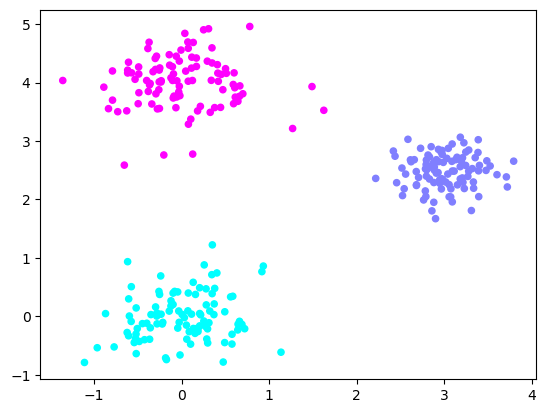

In [24]:
from sklearn.datasets import make_blobs

Xp, yp = make_blobs(n_samples=300, n_features=2, centers=[[0, 0], [3, 2.5], [0, 4]], 
                    cluster_std=[0.45, 0.3, 0.45], random_state=96)
plt.scatter(Xp[:,0], Xp[:,1], c=yp, cmap=plt.get_cmap("cool"), s=20)

Iskoristite skup podataka `Xp` dan gore. Isprobajte vrijednosti hiperparametra $K$ iz $[0,1,\ldots,15]$. Ne trebate dirati nikakve hiperparametre modela osim $K$. Iscrtajte krivulju od $J$ u ovisnosti o broju grupa $K$. Metodom lakta/koljena odredite vrijednost hiperparametra $K$.

In [25]:
from sklearn.cluster import KMeans

Ks = np.arange(1, 16, 1)
inertias = []

for K in Ks:
    kmeans = KMeans(n_clusters=K).fit(Xp)
    inertias.append(kmeans.inertia_)

/home/mplinux/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mplinux/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mplinux/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mplinux/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

Text(0, 0.5, 'J')

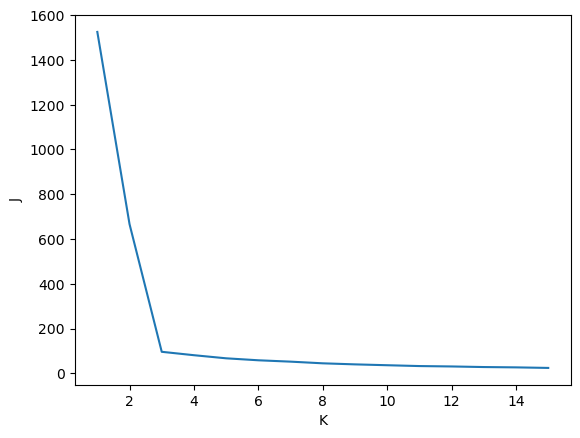

In [26]:
plt.plot(Ks, inertias)
plt.xlabel('K')
plt.ylabel('J')

**Q:** Koju biste vrijednost hiperparametra $K$ izabrali na temelju ovog grafa? Zašto? Je li taj odabir optimalan? Kako to znate? 

**A:** Odabrao bih K=3. Vidimo nagal pad u vrijednosti kriterijske funkcije J kada je K=3. Razlog tome je što je to broj prirodnih grupa.

**Q:** Je li ova metoda robusna?

**A:** Ne, metoda lakta ne radi uvijek.

**Q:** Možemo li izabrati onaj $K$ koji minimizira pogrešku $J$? Objasnite.

**A:** Možemo, taj K jednak je broju primjera koje klasificiramo tj. N. Funkcija pogreške $J$ monotono opada s brojem primjera zato što računa udaljenost centroida do svih primjera koji spadaju pod taj centroid.

#### (b)  
Odabir vrijednosti hiperparametra $K$ može se obaviti na mnoštvo načina. Pored metode lakta/koljena, moguće je isto ostvariti i analizom siluete (engl. *silhouette analysis*). Za to smo pripremili funkciju `plot_silhouette` koja za dani broj grupa i podatke iscrtava prosječnu vrijednost koeficijenta siluete i vrijednost koeficijenta svakog primjera (kroz grupe). 

Vaš je zadatak isprobati različite vrijednosti hiperparametra $K$, $K \in \{2, 3, 5\}$ i na temelju dobivenih grafova odlučiti se za optimalan $K$.

/home/mplinux/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_453324/3145991939.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Dark2")
/tmp/ipykernel_453324/3145991939.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Dark2")


For n_clusters = 2 The average silhouette_score is : 0.59280796169837


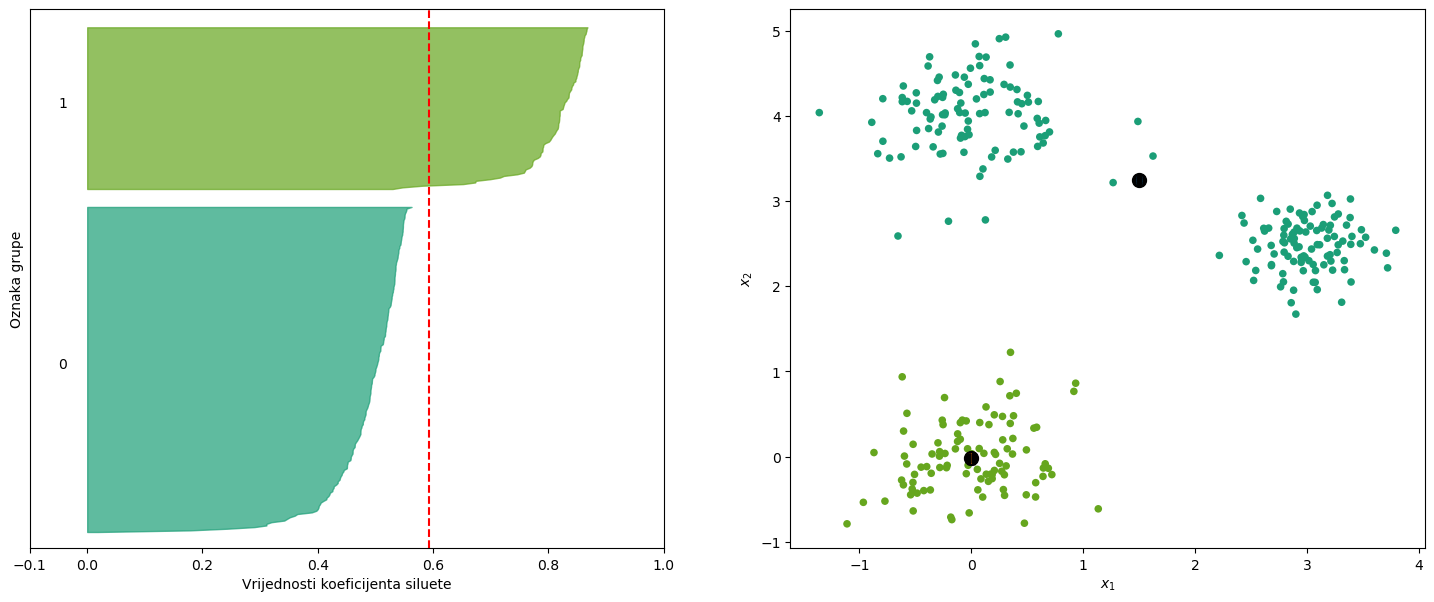

/home/mplinux/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_453324/3145991939.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Dark2")
/tmp/ipykernel_453324/3145991939.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Dark2")


For n_clusters = 3 The average silhouette_score is : 0.7975462212061406


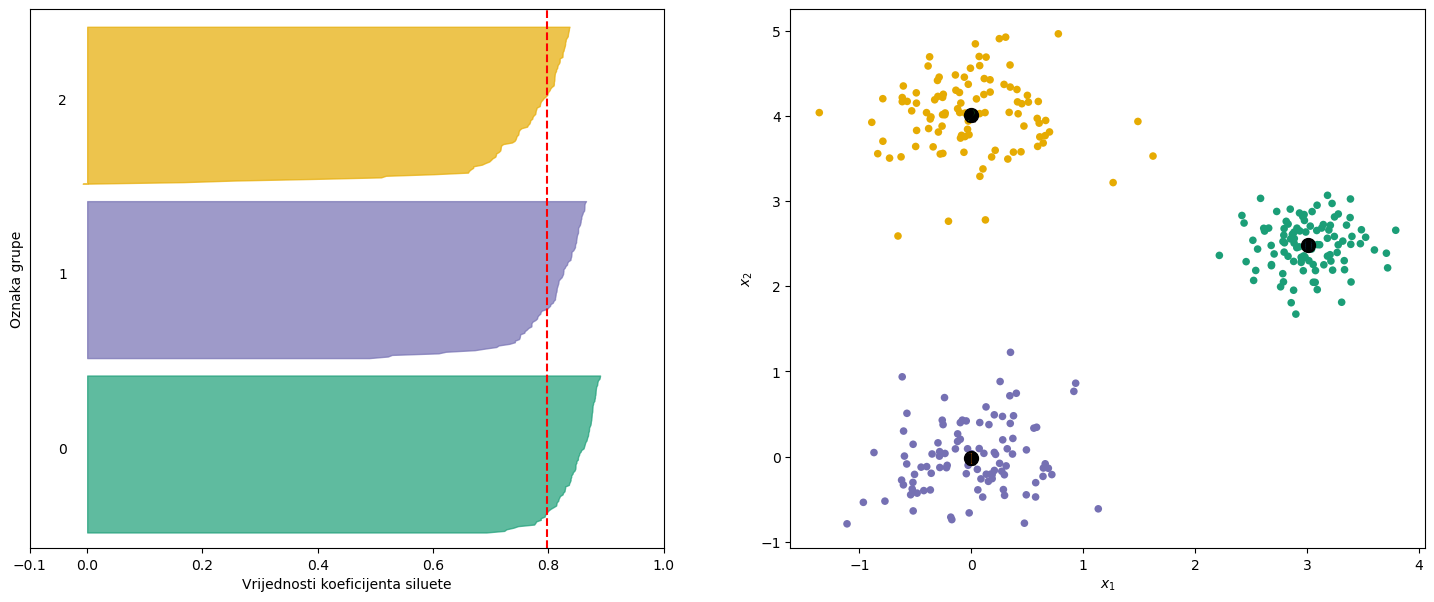

/home/mplinux/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_453324/3145991939.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Dark2")
/tmp/ipykernel_453324/3145991939.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Dark2")


For n_clusters = 5 The average silhouette_score is : 0.5059026123508755


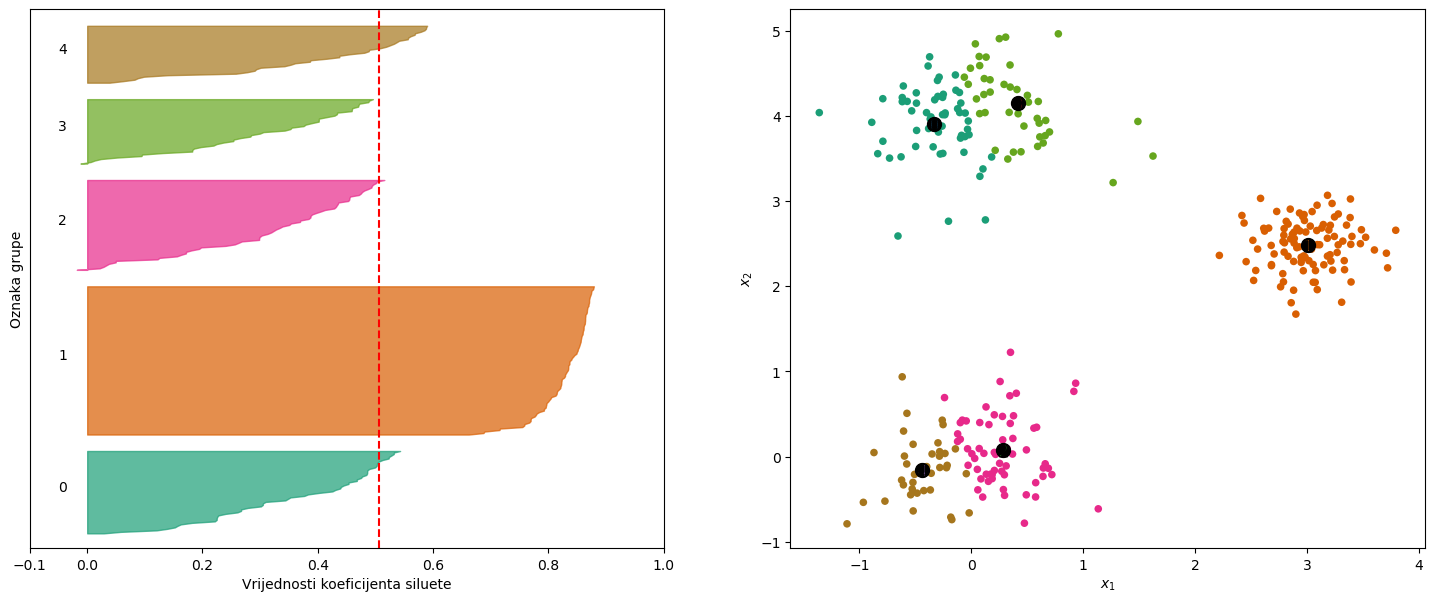

In [27]:
Ks = [2, 3, 5]

for K in Ks:
    plot_silhouette(n_clusters=K, X=Xp)

**Q:** Kako biste se gledajući ove slike odlučili za $K$?

**A:** Tamo gdje su sve vrijednosti silueta za pojedinu grupu > prosječne vrijednosti siluete. 

**Q:** Koji su problemi ovog pristupa?

**A:** Što ih možemo jedino primijeniti kada računamo udaljenost između primjera u vektorskom prostoru.

#### (c)  
U ovom i sljedećim podzadatcima fokusirat ćemo se na temeljne pretpostavke algoritma k-sredina te što se događa ako te pretpostavke nisu zadovoljene. 

Prvo, krenite od podataka `X1`, koji su generirani korištenjem funkcije [`datasets.make_blobs`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html), koja stvara grupe podataka pomoću izotropskih Gaussovih distribucija.

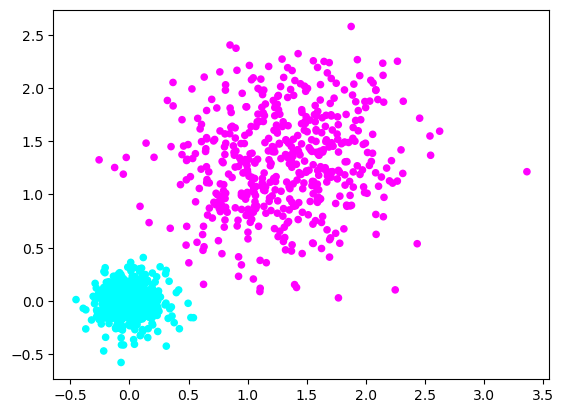

In [28]:
from sklearn.datasets import make_blobs

X1, y1 = make_blobs(n_samples=1000, n_features=2, centers=[[0, 0], [1.3, 1.3]], cluster_std=[0.15, 0.5], random_state=96)
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap=plt.get_cmap("cool"), s=20)

Naučite model k-sredina (idealno pretpostavljajući $K=2$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

In [29]:
def plot_k_means(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto').fit(X)

    plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap=plt.get_cmap("cool"))
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', c='r', label='centers')
    plt.legend(loc='upper right')
    plt.show()
    

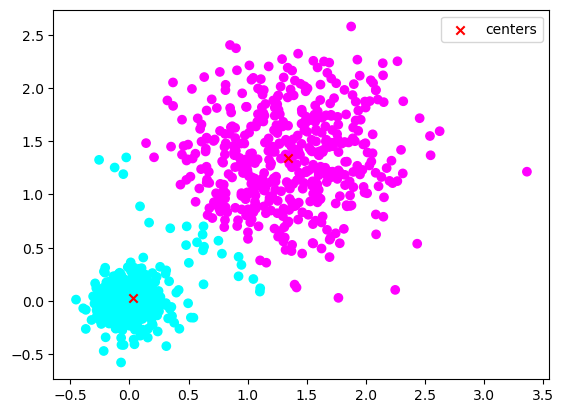

In [30]:
plot_k_means(X=X1, n_clusters=2)

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-sredina ovdje narušena?

**A:** Dio primjera krivo klasificiran -> narušena pretpostavka da svaki primjer pripada grupi čiji mu je centroid najbliži.

**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

**A:** Koristit drugu mjeru udaljenosti (možda Mahalanobisovu udaljenost).

#### (d)

Isprobajte algoritam k-sredina na podatcima generiranim korištenjem funkcije [`datasets.make_circles`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html), koja stvara dvije grupe podataka tako da je jedna unutar druge.

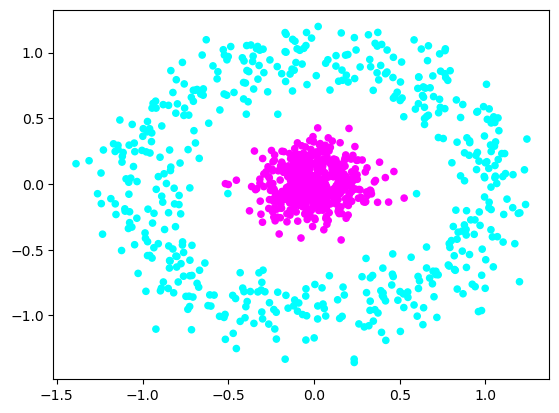

In [31]:
from sklearn.datasets import make_circles

X2, y2 = make_circles(n_samples=1000, noise=0.15, factor=0.05, random_state=96)
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap=plt.get_cmap("cool"), s=20)

Ponovno, naučite model k-sredina (idealno pretpostavljajući $K=2$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

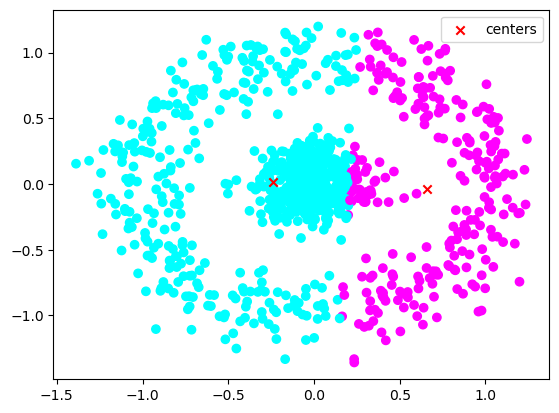

In [32]:
plot_k_means(X=X2, n_clusters=2)

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-sredina ovdje narušena?

**A:** Dva kruga jedan unutar drugog -> nisu odvojivi s K-means -> narušena pretpostavka da su centroidi grupa različiti.

**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

**A:** Osigurati da su centroidi dvaju grupa različiti ili koristiti drugi algoritam.

#### (e)  
Završno, isprobat ćemo algoritam na sljedećem umjetno stvorenom skupu podataka:

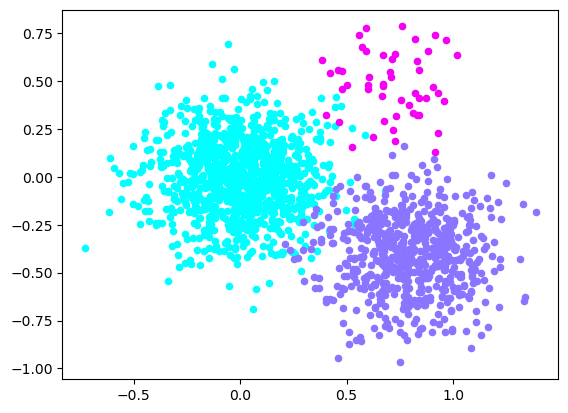

In [33]:
X31, y31 = make_blobs(n_samples=1000, n_features=2, centers=[[0, 0]], cluster_std=[0.2], random_state=69)
X32, y32 = make_blobs(n_samples=50, n_features=2, centers=[[0.7, 0.5]], cluster_std=[0.15], random_state=69)
X33, y33 = make_blobs(n_samples=600, n_features=2, centers=[[0.8, -0.4]], cluster_std=[0.2], random_state=69)
plt.scatter(X31[:,0], X31[:,1], c="#00FFFF", s=20)
plt.scatter(X32[:,0], X32[:,1], c="#F400F4", s=20)
plt.scatter(X33[:,0], X33[:,1], c="#8975FF", s=20)

# Just join all the groups in a single X.
X3 = np.vstack([X31, X32, X33])
y3 = np.hstack([y31, y32, y33])

Ponovno, naučite model k-sredina (ovaj put idealno pretpostavljajući $K=3$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

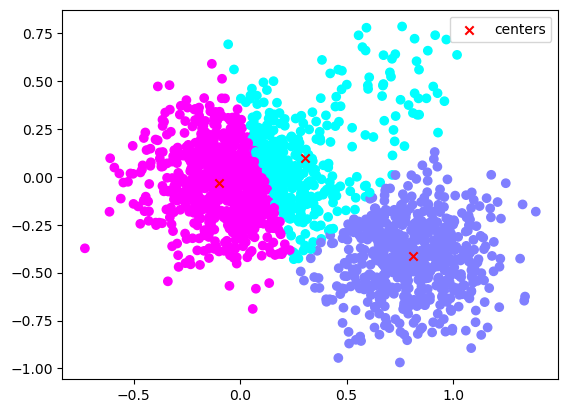

In [34]:
plot_k_means(X=X3, n_clusters=3)

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-sredina ovdje narušena?  
**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

### 7. Model Gaussovih mješavina

Sada kada ste se upoznali s ograničenjima algoritma k-sredina, isprobat ćete grupiranje modelom mješavine Gaussa (*Gaussian Mixture Models; GMM*), koji je generalizacija algoritma k-sredina (odnosno, algoritam k-sredina specijalizacija je GMM-a). Implementacija ovog modela dostupna je u [`mixture.GaussianMixture`](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html). Isprobajte ovaj model (s istim pretpostavkama o broju grupa) na podacima iz podzadataka (c)-(e). Ne morate mijenjati nikakve hiperparametre ni postavke osim broja komponenti.

In [35]:
from sklearn.mixture import GaussianMixture

In [36]:
def plot_gmm_predictions(X, n_components):
    gmm = GaussianMixture(n_components=n_components).fit(X)
    h = gmm.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=h, cmap=plt.get_cmap("cool"))
    plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], marker='x', c='r', label='centers')
    plt.legend(loc='upper right')
    plt.show()
    return h

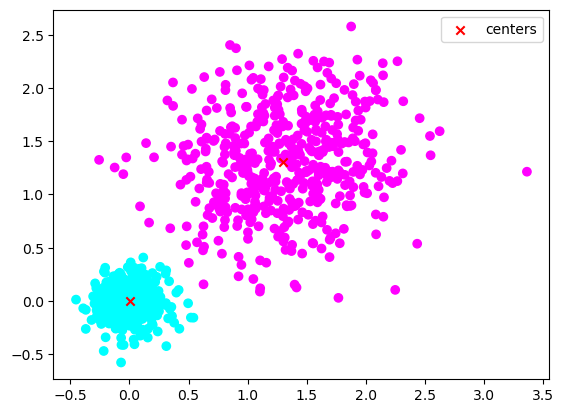

In [37]:
#c)
h1 = plot_gmm_predictions(X=X1, n_components=2)

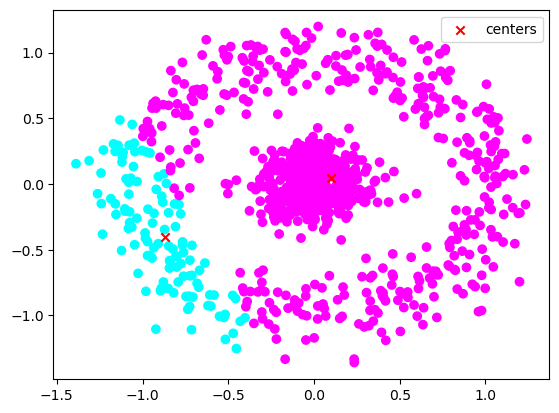

In [38]:
#d)
h2 = plot_gmm_predictions(X=X2, n_components=2)

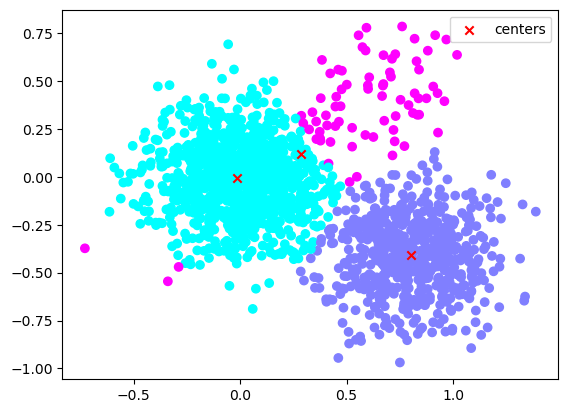

In [39]:
#e)
h3 = plot_gmm_predictions(X3, n_components=3)

### 8. Vrednovanje grupiranja

Kako vrednovati točnost modela grupiranja ako imamo stvarne oznake svih primjera (a u našem slučaju imamo, jer smo mi ti koji smo generirali podatke)? Često korištena mjera jest **Randov indeks** koji je zapravo pandan točnosti u zadatcima klasifikacije. Implementirajte funkciju `rand_index_score(y_gold, y_predict)` koja ga računa. Funkcija prima dva argumenta: listu stvarnih grupa kojima primjeri pripadaju (`y_gold`) i listu predviđenih grupa (`y_predict`). Dobro će vam doći funkcija [`itertools.combinations`](https://docs.python.org/2/library/itertools.html#itertools.combinations).

In [40]:
import itertools as it

def rand_index_score(y_gold, y_predict):
    pairs = it.combinations(range(len(y_gold)), 2)
    cnt = 0
    a = 0 # broj jednako oznacenih parova u istim grupama
    b = 0 # broj razlicito oznacenih barova u razlicitm grupama
    for p in pairs:
        # ako je par isto oznacen i ako je u istoj grupi
        if y_predict[p[0]] == y_predict[p[1]] and y_gold[p[0]] == y_gold[p[1]]:
            a += 1
        # ako je par razlicito oznacen i ako je u razlicitoj grupi
        elif y_predict[p[0]] != y_predict[p[1]] and y_gold[p[0]] != y_gold[p[1]]:
            b += 1
        cnt += 1
    
    rand_index = (a + b) / cnt
    print("a:", a, "\nb:", b, "\nrand_index:", rand_index)
    return rand_index
            

In [41]:
# primjer iz knjige
y_gold = [1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2]
y_predict = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2]
rand_index_score(y_gold=y_gold, y_predict=y_predict)
# GMM
# 1
rand_index_score(y1, h1)
# 2
rand_index_score(y2, h2)
# 3
rand_index_score(y3, h3)

a: 22 
b: 26 
rand_index: 0.6153846153846154
a: 249500 
b: 250000 
rand_index: 1.0
a: 205769 
b: 56500 
rand_index: 0.525063063063063
a: 660241 
b: 0 
rand_index: 0.485319661135307


0.485319661135307

**Q:** Zašto je Randov indeks pandan točnosti u klasifikacijskim problemima?  
**Q:** Koji su glavni problemi ove metrike?   
**Q:** Kako vrednovati kvalitetu grupiranja ako nenamo stvarne oznake primjera? Je li to uopće moguće?